## Crime Patterns and Arrest Trends Due to SocioEconomic Disparity: A Data Science Analysis
### Project Introduction
Our project investigates disparities in crime and arrest trends across neighborhoods in NYC, with a focus on how these trends correlate with income levels, race demographics, and geographic location.
#### Research Questions
- **Do crime and arrest rates vary by location?** | **Do areas with lower income experience higher police activity and crime rates?** | **Do we see similar trends of systematic discrimination in areas with higher population of people of color?**
#### Data Sources
- **NYPD Shooting Incident | Data** **NYC Crimes 2001–Present** |  **NYC Arrests Data**
### Project Status
Since our check-in proposal slides, there has been a significant change to the project scope. Initially, we planned to analyze crime and arrest trends using datasets from Chicago. However, due to data limitations, we decided to switch our focus to datasets from the NYPD. This change aligns with our original objective of analyzing crime and arrest trends by location,and racial demographics.

In [18]:
import pandas as pd
import numpy as np
import re                        
from datetime import datetime
import zipfile
import matplotlib.pyplot as plt   
import seaborn as sns
import plotly.express as px

In [19]:
with zipfile.ZipFile("NYPD_Hate_Crimes.zip", "r") as z:
    with z.open("NYPD_Hate_Crimes.csv") as f:
        df_hate_crimes = pd.read_csv(f)
columns_to_drop = ['Complaint Precinct Code', 'Law Code Category Description',  'PD Code Description','Bias Motive Description','Month Number','Patrol Borough Name','Full Complaint ID']
df_hate_crimes = df_hate_crimes.drop(columns=[col for col in columns_to_drop if col in  df_hate_crimes.columns])
df_hate_crimes = df_hate_crimes.drop_duplicates()
df_hate_crimes = df_hate_crimes.dropna()
#print(df_hate_crimes.head())

In [20]:
with zipfile.ZipFile("NYPD_Arrest_Data__Year_to_Date_.zip", "r") as z:
    with z.open("NYPD_Arrest_Data__Year_to_Date_.csv") as f:
        df_arrest = pd.read_csv(f)
df_arrest.replace("(null)", np.nan, inplace=True)
#print("Columns in the Arrest DataFrame:")
#print(df_arrest.columns)
columns_to_drop = ['PD_CD', 'PD_DESC', 'KY_CD', 'LAW_CODE', 'LAW_CAT_CD','JURISDICTION_CODE', 'X_COORD_CD', 'Y_COORD_CD','Latitude', 'Longitude', 'New Georeferenced Column'
]
columns_to_drop = [col for col in columns_to_drop if col in df_arrest.columns]
#print(f"Columns to drop: {columns_to_drop}")
df_arrest.drop(columns=columns_to_drop, inplace=True)
df_arrest.dropna(inplace=True)
#print("Cleaned Arrest DataFrame:")
#print(df_arrest.head())

In [21]:
df_shooting = pd.read_csv("NYPD_shooting_incident_data__Historic__.csv")
df_shooting.replace("(null)", np.nan, inplace=True)
columns_to_keep = ['OCCUR_DATE', 'BORO', 'VIC_RACE', 'VIC_AGE_GROUP', 'VIC_SEX', 'PERP_SEX', 'PERP_RACE', 'PRECINCT']
df_shooting = df_shooting[columns_to_keep]
df_shooting.dropna(inplace=True)
#print(df_shooting.head())

In [22]:
df_hate_crimes.rename(columns={'Arrest Date': 'DATE', 'County': 'BORO'}, inplace=True)
df_hate_crimes['DATE'] = pd.to_datetime(df_hate_crimes['DATE'])
df_arrest.rename(columns={'ARREST_DATE': 'DATE', 'ARREST_BORO': 'BORO'}, inplace=True)
df_arrest['DATE'] = pd.to_datetime(df_arrest['DATE'])
df_shooting.rename(columns={'OCCUR_DATE': 'DATE'}, inplace=True)
df_shooting['DATE'] = pd.to_datetime(df_shooting['DATE'])
merged_df = pd.merge(df_arrest, df_shooting, on=['DATE', 'BORO'], how='outer')
merged_df = pd.merge(merged_df, df_hate_crimes, on=['DATE', 'BORO'], how='outer')
#print(merged_df.head())
merged_df.to_csv("merged_nypd_data.csv", index=False)
print(merged_df.head(2))

   ARREST_KEY       DATE OFNS_DESC   BORO  ARREST_PRECINCT AGE_GROUP  \
0         NaN 2006-01-01       NaN  BRONX              NaN       NaN   
1         NaN 2006-01-01       NaN  BRONX              NaN       NaN   

  PERP_SEX_x PERP_RACE_x        VIC_RACE VIC_AGE_GROUP VIC_SEX PERP_SEX_y  \
0        NaN         NaN           BLACK           <18       M          M   
1        NaN         NaN  WHITE HISPANIC         18-24       M          M   

      PERP_RACE_y  PRECINCT  Complaint Year Number Record Create Date  \
0           BLACK      48.0                    NaN                NaN   
1  WHITE HISPANIC      44.0                    NaN                NaN   

  Offense Description Offense Category Arrest Id  
0                 NaN              NaN       NaN  
1                 NaN              NaN       NaN  


In [23]:
race_counts = merged_df['PERP_RACE_y'].value_counts()
#print(race_counts)
race_counts = merged_df['VIC_RACE'].value_counts()
#print(race_counts)
sex_counts = merged_df['PERP_SEX_y'].value_counts()
#print(sex_counts)
age_group_counts = merged_df['AGE_GROUP'].value_counts()
#print(age_group_counts)
age_group_counts = merged_df['AGE_GROUP'].value_counts()
#print(age_group_counts)
merged_df['BORO'] = merged_df['BORO'].replace({
    'K': 'BROOKLYN', 
    'M': 'MANHATTAN', 
    'B': 'BRONX', 
    'Q': 'QUEENS', 
    'S': 'STATEN ISLAND',
    'KINGS': 'BROOKLYN',
    'NEW YORK': 'MANHATTAN',
    'RICHMOND': 'STATEN ISLAND'})
boro_counts = merged_df['BORO'].value_counts()
#print(boro_counts)
offense_desc_counts = merged_df['OFNS_DESC'].value_counts()
#print(offense_desc_counts)
precinct_counts = merged_df['PRECINCT'].value_counts()
#print(precinct_counts)

# Exploratory Data Analysis: Merged DATASET
This EDA explores a dataset of arrest records from NYC, including details about arrests, perpetrators, victims, and locations. We highlight key trends and summarize the dataset below.
#### Data Description
The dataset contains the following columns:
**ARREST_KEY:** A unique identifier for each arrest.  **DATE:** The date of the arrest or incident. **OFNS_DESC:** Offense description. **BORO:** The NYC borough where the arrest occurred. **ARREST_PRECINCT:** The precinct where the arrest was made. **AGE_GROUP:** Age group of the perpetrator. **PERP_SEX_x:** Sex of the perpetrator. **PERP_RACE_x:** Race of the perpetrator. **VIC_RACE:** Race of the victim. **VIC_AGE_GROUP:** Age group of the victim. **VIC_SEX:** Sex of the victim. **PERP_SEX_y:** Another column for perpetrator sex.**PERP_RACE_y:** Another column for perpetrator race. **PRECINCT:** Precinct number, likely related to the incident. **Complaint Year Number:** Year of the complaint. **Record Create Date:** Date the record was created. **Offense Description:** Detailed offense description.**Offense Category:** Category of the offense. **Arrest Id:** Another identifier for the arrest.
#### FINDINGS OF MERGED DATA 
##### 1. **Racial Distribution of Crime Perpetrators(PERP_RACE_y)?**
- **BLACK:** 11,967 incidents **WHITE HISPANIC:** 2,517 incidents **UNKNOWN:** 1,837 incidents **BLACK HISPANIC:** 1,398 incidents **WHITE:** 298 incidents **ASIAN / PACIFIC ISLANDER:** 170 incidents **AMERICAN INDIAN/ALASKAN NATIVE:** 2 incidents
##### 2. **Racial Distribution of Crime Victims (VIC_RACE)**
- **BLACK:** 12,335 victims **WHITE HISPANIC:** 3,064 victims **BLACK HISPANIC:** 1,852 victims **WHITE:** 563 victims **ASIAN / PACIFIC ISLANDER:** 316 victims **UNKNOWN:** 51 victims **AMERICAN INDIAN/ALASKAN NATIVE:** 8 victims
##### 3. **Borough Distribution:**
- **Brooklyn (K):** 72,325 incidents **Manhattan (M):** 61,969 incidents **Bronx (B):** 58,521 incidents **Queens (Q):** 56,633 incidents **Staten Island (S):** 11,055 incidents
##### 4. **Age Group Distribution:**
- **25-44 years:** 152,034 incidents **45-64 years:** 51,121 incidents **18-24 years:** 43,174 incidents **Under 18 years:** 9,525 incidents **65+ years:** 4,649 incidents
#### Preliminary Conclusions
- **Victim Profile:** Most victims are male, with **Black** being the most common race among victims in the sample.
- **Perpetrator Profile:** Perpetrators are predominantly **male**, and the most common races among perpetrators are **Black** and **White Hispanic**.

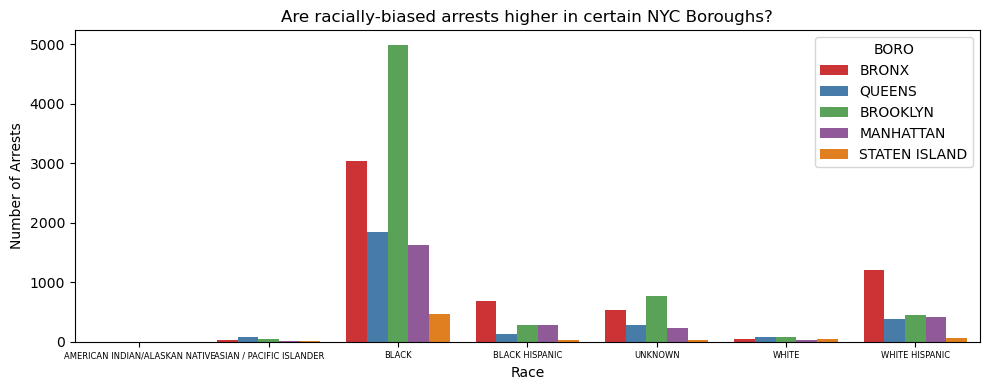

In [24]:
bias_race_boro = merged_df[['PERP_RACE_y', 'BORO']].dropna()
race_boro_counts = bias_race_boro.groupby(['PERP_RACE_y', 'BORO']).size().reset_index(name='Arrest Count')
plt.figure(figsize=(10, 4))
sns.barplot(data=race_boro_counts, x='PERP_RACE_y', y='Arrest Count', hue='BORO', palette='Set1')
plt.title('Are racially-biased arrests higher in certain NYC Boroughs?' )
plt.xlabel('Race')
plt.ylabel('Number of Arrests')
plt.xticks(fontsize=6)
plt.tight_layout()
plt.show()

                                    precision    recall  f1-score   support

Ethnicity/National Origin/Ancestry       0.82      0.93      0.88        15
                            Gender       1.00      0.33      0.50         3
                        Race/Color       0.70      1.00      0.82         7
       Religion/Religious Practice       0.90      0.64      0.75        14
                Sexual Orientation       0.20      0.25      0.22         4

                          accuracy                           0.74        43
                         macro avg       0.72      0.63      0.63        43
                      weighted avg       0.78      0.74      0.74        43



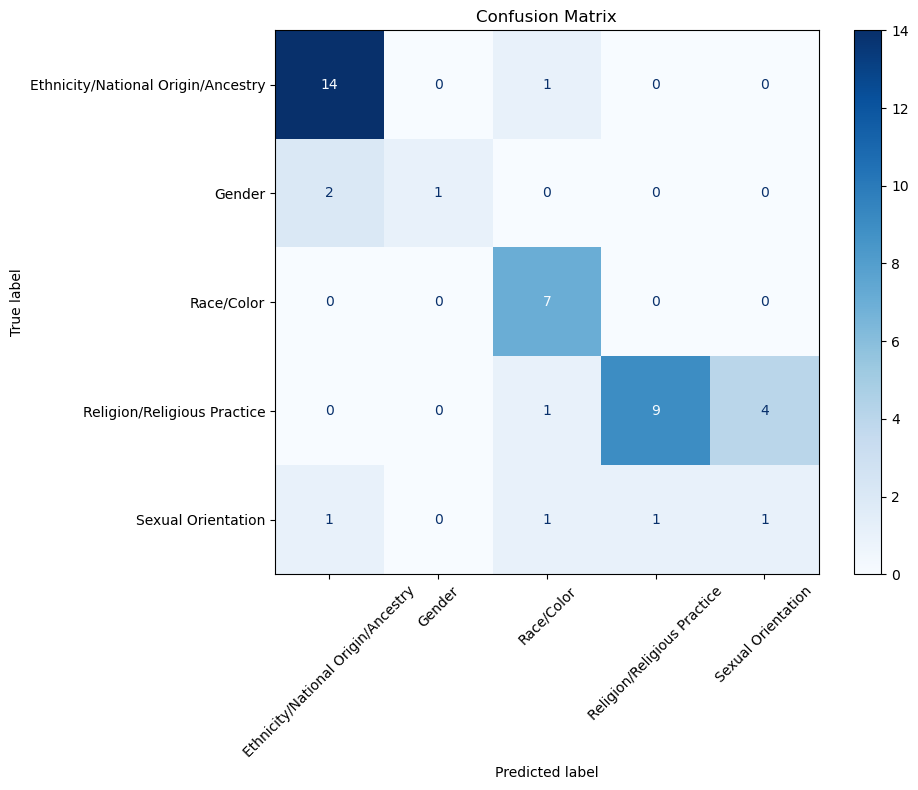


Top 15 Features:
                                 Feature  Importance
14                       assault related    0.184383
13                               assault    0.153230
5                         VIC_RACE_WHITE    0.104776
30                           text_length    0.094424
2                         VIC_RACE_BLACK    0.091775
0                               PRECINCT    0.061289
3                VIC_RACE_BLACK HISPANIC    0.046414
17                                felony    0.045841
1      VIC_RACE_ASIAN / PACIFIC ISLANDER    0.043842
7   PERP_RACE_y_ASIAN / PACIFIC ISLANDER    0.028782
6                VIC_RACE_WHITE HISPANIC    0.028614
8                      PERP_RACE_y_BLACK    0.025418
27                               related    0.024710
15                              criminal    0.019050
19                                   law    0.017454


In [48]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix, hstack
import matplotlib.pyplot as plt

# 1. Data Loading with Strict Types
dtype_dict = {
    'VIC_RACE': 'category',
    'PERP_RACE_y': 'category',
    'PRECINCT': 'float32',
    'Offense Description': 'string',
    'Offense Category': 'category'
}
df = pd.read_csv("merged_nypd_data.csv", dtype=dtype_dict, low_memory=False)

# 2. Data Cleaning
df = df[['VIC_RACE', 'PERP_RACE_y', 'PRECINCT', 'Offense Description', 'Offense Category']].dropna()
df['clean_text'] = df['Offense Description'].str.lower().str.replace(r'[^\w\s]', '', regex=True)
df['text_length'] = df['clean_text'].str.len().astype('float32')

# 3. Target Preparation
le = LabelEncoder()
y = le.fit_transform(df['Offense Category'])

# 4. Feature Engineering
# Demographic features (dense for XGBoost compatibility)
demo_features = pd.get_dummies(
    df[['VIC_RACE', 'PERP_RACE_y', 'PRECINCT']].fillna('UNKNOWN'),
    drop_first=True
).astype('float32')

# Text features (sparse)
tfidf = TfidfVectorizer(
    max_features=150,
    stop_words='english',
    ngram_range=(1, 2),
    min_df=2
)
text_features = tfidf.fit_transform(df['clean_text'])

# Combine features (convert demo to sparse)
X = hstack([csr_matrix(demo_features), text_features, csr_matrix(df[['text_length']])])

# 5. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# 6. Handle Class Imbalance
smote = SMOTE(random_state=42, k_neighbors=2)
X_res, y_res = smote.fit_resample(X_train, y_train)

# 7. Model Training
xgb = XGBClassifier(
    max_depth=4,
    learning_rate=0.1,
    n_estimators=200,
    objective='multi:softprob',
    random_state=42,
    tree_method='hist',
    eval_metric='mlogloss'
)
xgb.fit(X_res, y_res)

# 8. Evaluation
y_pred = xgb.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion Matrix Visualization
fig, ax = plt.subplots(figsize=(10, 8))
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=le.classes_,
    ax=ax,
    cmap='Blues',
    xticks_rotation=45
)
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# 9. Feature Analysis - Fixed Version
feature_names = (
    list(demo_features.columns) + 
    [f"text_{i}" for i in range(text_features.shape[1])] +
    ['text_length']
)

# Get importance scores
importance = xgb.feature_importances_
top_features = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
}).sort_values('Importance', ascending=False).head(15)

# Map text features to actual words - Fixed Implementation
vocab = tfidf.get_feature_names_out()
top_features['Feature'] = top_features['Feature'].apply(
    lambda x: vocab[int(x.split('_')[1])] if x.startswith('text_') and x.split('_')[1].isdigit() else x
)

print("\nTop 15 Features:")
print(top_features.to_string())

In [28]:
!pip install xgboost

In [29]:
import xgboost as xgb
print(xgb.__version__)  

3.0.0


REFLECTION:
In our final project, we've tackled challenges with integrating complex NYPD data sets, uncovering crime rate patterns and arrest biases which highlight socio-economic impacts. We've managed initial visualizations and are now focused on enhancing our machine learning model's predictive accuracy, which is currently underperforming. As we slightly lag behind schedule in model analysis, no major changes to the project scope are planned yet. Our next steps include refining data processes and drafting our final report, relying on our team's strong collaboration to navigate these challenges.